In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob, os, random, time
import tensorflow as tf
import tensorflow.keras as keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_auc_score

# print(tf.__version__)

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [2]:
root_path = '/mnt/Mel/Mel/fan'
labels = {0: 'normal', 1: 'abnormal'}

In [3]:
rate = 0.3
batchsize = 64
classmode = 'binary'
picsize = (1000,400)
inputshape = (1000,400,3)

# 构造ImageDataGenerator对象
train_datagen = ImageDataGenerator(
    rescale=1. / 255,                   # 数据缩放，把像素点的值除以255，使之在0到1之间
    #shear_range=0.1,                    # 错切变换角度
    #zoom_range=0.5,                     # 随机缩放范围
    #width_shift_range = 0.5,            # 除以总宽度的值
    #height_shift_range = 0.5,           # 除以总高度的值
    #horizontal_flip=True,               # 随机水平暗转
    #vertical_flip = True,               # 随机垂直翻转
    validation_split = rate             # 保留用于验证的图像比例为0.3
)

# 归一化验证集
val_datagen = ImageDataGenerator(
    rescale=1. / 255,                  # 数据缩放，把像素点的值除以255，使之在0到1之间
    validation_split= rate)              # 保留用于验证的图像比例为0.3

In [4]:
# 对训练集进行数据增强
train_generator = train_datagen.flow_from_directory(
    root_path+'',              # 目标数据的路径
    target_size= picsize,            # 所有的图片将被调整的尺寸
    batch_size= batchsize,                     # 每批传入数据的大小
    class_mode= classmode,          # 决定返回标签的类型。这里采用 2D one-hot 编码标签
    subset='training',                 # 数据子集
    seed=None)                            # 可选随机种子

# 对测试集进行数据增强
val_generator = val_datagen.flow_from_directory(
    root_path+'',              # 目标数据的路径
    target_size= picsize,            # 所有的图片将被调整的尺寸
    batch_size=  batchsize,                     # 每批传入数据的大小
    class_mode= classmode,          # 决定返回标签的类型。这里采用 2D one-hot 编码标签
    subset='validation',               # 数据子集
    seed=None)                            # 可选随机种子


Found 3886 images belonging to 2 classes.
Found 1664 images belonging to 2 classes.


In [6]:
### model


model = Sequential()
# 卷积层
# filter=32表示卷积滤波器个数为32
# kernel_size=3表示所有空间维度指定相同的值
# padding='same'表示padding完尺寸与原来相同
# activation='relu'使用relu作为激活函数
# input_shape=(300, 300, 3)表示输入图像的尺寸为300x300，且有3个颜色通道

#1
model.add(Conv2D(filters=32, kernel_size=5, padding='same', activation='relu', input_shape= inputshape))
# 池化层
# 使用最大池化层，且最大池化的窗口为2
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.5))
#2
model.add(Conv2D(filters=64, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.5))
#3
model.add(Conv2D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.5))

model.add(Flatten())  # 扁平化参数
# 全连接层
# 全连接层输出的空间维度为64
# 激活函数采用relu
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
# 全连接层
# 全连接层输出的空间维度为6
# 激活函数采用softmax
model.add(Dense(1, activation='sigmoid'))
# 完成架构搭建后，最后输出模型汇总

def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),           # 损失函数使用交叉熵
                   optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),                     # 设置优化器
                   metrics=['accuracy', auroc])                 # 设置评估指标为准确率

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 1000, 400, 32)     2432      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 333, 133, 32)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 333, 133, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 333, 133, 64)      51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 44, 64)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 111, 44, 64)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 111, 44, 128)     

In [7]:
### train
time_model = time.time() # 记录训练开始时间
print(1)
history_fit = model.fit(train_generator,                # 增强的数据集
                        epochs=50,                      # 迭代总轮数，这里设置为50次，你可以在实验是增加epoch次数，提升准确率
                        steps_per_epoch=(3886//batchsize),       # generator 产生的总步数（批次样本）
                        validation_data=val_generator,  # 验证数据的生成器
                        validation_steps=(1664//batchsize)         # 在停止前 generator 生成的总步数（样本批数）
                        )

# model.summary()

########################################################################
time_end = time.time()
minute = (time_end - time_model) // 60
second = (time_end - time_model) % 60
print('\nModel Time cost', minute, 'min ', second, ' sec')

1


2022-05-07 02:03:11.053642: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-05-07 02:03:14.641410: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


60/60 [==============================] - 210s 3s/step - loss: 0.6871 - accuracy: 0.6732 - auroc: 0.4832 - val_loss: 0.6805 - val_accuracy: 0.7344 - val_auroc: 0.4253
Epoch 2/50
60/60 [==============================] - 187s 3s/step - loss: 0.6059 - accuracy: 0.7255 - auroc: 0.5047 - val_loss: 0.6742 - val_accuracy: 0.7344 - val_auroc: 0.4683
Epoch 3/50
60/60 [==============================] - 179s 3s/step - loss: 0.6093 - accuracy: 0.7299 - auroc: 0.4757 - val_loss: 0.6765 - val_accuracy: 0.7344 - val_auroc: 0.4133
Epoch 4/50
60/60 [==============================] - 181s 3s/step - loss: 0.6012 - accuracy: 0.7331 - auroc: 0.4951 - val_loss: 0.6719 - val_accuracy: 0.7344 - val_auroc: 0.3050
Epoch 5/50
60/60 [==============================] - 182s 3s/step - loss: 0.5957 - accuracy: 0.7305 - auroc: 0.5085 - val_loss: 0.6723 - val_accuracy: 0.7344 - val_auroc: 0.3189
Epoch 6/50
60/60 [==============================] - 180s 3s/step - loss: 0.5959 - accuracy: 0.7302 - auroc: 0.5050 - val_loss:

KeyboardInterrupt: 

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

train_predictions = model.predict(train_generator, batch_size= batchsize)
test_predictions = model.predict(val_generator, batch_size= batchsize)
model.predict(train_generator, batch_size= batchsize)
plot_roc("Train Baseline", train_labels, train_predictions, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

type(train_predictions)

KeyError: 'auc'

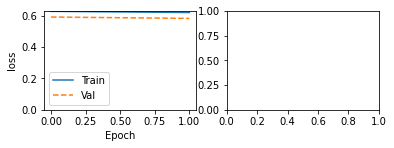

In [13]:
import sklearn

def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                  linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()
plot_metrics(history_fit)


In [133]:
# 将训练过程的中间信息保留位json文件
with open(root_path + "/Model/history_fit.json", "w") as json_file:
    json_file.write(str(history_fit))

In [134]:
# 查看训练过程的准确率变化情况
acc = history_fit.history['accuracy']

# 查看验证过程的准确率变化情况
val_acc = history_fit.history['val_accuracy']

# 查看训练过程的损失值变化情况
loss = history_fit.history['loss']

# 查看验证过程的损失值变化情况
val_loss = history_fit.history['val_loss']



In [152]:
acc = np.array(acc)
np.save('acc.npy',acc)
val_acc = np.array(val_acc)
np.save('val_acc.npy',val_acc)
loss = np.array(loss)
np.save('loss.npy',loss)
val_loss = np.array(val_loss)
np.save('val_loss.npy',val_loss)

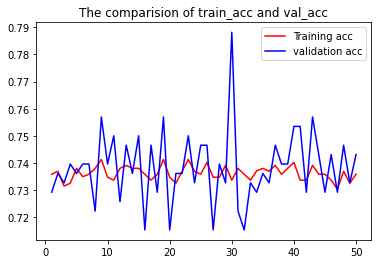

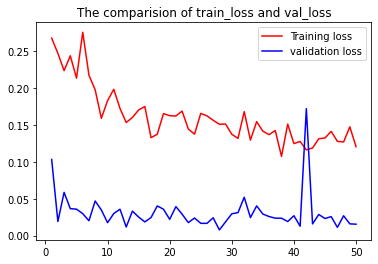

In [135]:
# 可视化训练集和验证集准确率的变化情况
epochs = range(1, len(acc) + 1) 
plt.figure("acc")
plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('The comparision of train_acc and val_acc')
plt.legend()
plt.show()

# 可视化训练集和验证集损失值的变化情况
plt.figure("loss")
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('The comparision of train_loss and val_loss')
plt.legend()
plt.show()

In [138]:
model_json=model.to_json()
with open(root_path+'/Model/model_json.json', "w") as json_file:
    json_file.write(model_json)
model.save_weights(root_path+'/Model/model_weight.h5')

In [139]:
model.save(root_path+'/Model/model.h5')
print('model saved')

model saved


In [145]:
json_file = open(root_path + '/Model/model_json.json')      # 加载模型结构文件
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)                  # 结构文件转化为模型
# 加载权重
model.load_weights(root_path + '/Model/model_weight.h5')    # h5文件保存模型的权重数据

img_path = "00000000.png"                 # 测试数据路径
img = image.load_img(img_path, target_size=(1000, 400)) # 加载图片并将其转换为300x300的尺寸
img = image.img_to_array(img)                          # 将图片数据转换为array形式
img = np.expand_dims(img, axis=0)                      # 添加一个维度，维度为0
result = model.predict(img)                            # 图片预测
pd1 = result

img_path = "00000000_1651577091.png"                 # 测试数据路径
img = image.load_img(img_path, target_size=(1000, 400)) # 加载图片并将其转换为300x300的尺寸
img = image.img_to_array(img)                          # 将图片数据转换为array形式
img = np.expand_dims(img, axis=0)                      # 添加一个维度，维度为0
result = model.predict(img)                            # 图片预测
pd2 = result


img_path = "mnt/dataset/normal/00000004.png"                 # 测试数据路径
img = image.load_img(img_path, target_size=(1000, 400)) # 加载图片并将其转换为300x300的尺寸
img = image.img_to_array(img)                          # 将图片数据转换为array形式
img = np.expand_dims(img, axis=0)                      # 添加一个维度，维度为0
result = model.predict(img)                            # 图片预测
pd3 = result

print(pd1,'/n',pd2)
print(pd3)



FileNotFoundError: [Errno 2] No such file or directory: 'dataset/normal/00000004.png'

In [ ]:
def generate_result(result):
    for i in range(2):
        if(result[0][i] == 1):
            return labels[i]

print(generate_result(result))